# 1. Segmentation

In the final step, we will perform the segmentation and wear measurement. We are going to use unseen images for the model, perform segmentation on these images, and finally measure the wear thickness to plot the corresponding VB curve for each cutting edge.

For better segmentation results, we will use a well-trained model with a larger number of training datasets, resulting in improved accuracy. However, before proceeding with the segmentation task, certain preprocessing steps are required to ensure optimal results.


# 1.1. Image Alignment

Before delving into segmentation, it's essential to address potential issues stemming from image acquisition, such as image shifting. To mitigate these issues and ensure consistency across images, we will employ image alignment techniques.

By aligning the images based on a reference or source image, we can ensure that the cutting edge, or the region of interest, remains roughly in the same position across all images. This not only simplifies the segmentation process but also improves the accuracy of subsequent measurements, such as wear thickness calculation.

With the images properly aligned, we can proceed confidently to the segmentation phase, where we'll extract meaningful insights regarding wear thickness and plot the corresponding VB curve.

<div style="text-align: center;">
    <img src="VC_Images/Img_04.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>
'
<div style="text-align: center;">
    <img src="VC_Images/Img_05.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

# 1.1.1. Extracting The Reference Image

In [17]:
import cv2 
import os 
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras.utils import normalize
from keras.models import load_model
import pandas as pd
from sklearn.cluster import DBSCAN
import csv

In [4]:
# Get the current working directory
current_dir = os.getcwd()

# Now create the path to the folder with Images for Alignmnet
folder = os.path.join(current_dir, 'Image_Dataset/07_Segmentation_Alignment')

# Get a sorted list of all image files in the folder
image_files = [filename for filename in os.listdir(folder) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# If an image is found, process it
imgRef_path  = os.path.join(folder, image_files[0])
imgRef = cv2.imread(imgRef_path)  
imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY) 
sz = imgRef_grey.shape
print("First image found:", image_files[0])

First image found: image0002074.jpg


# 1.1.2. Aligning Target Images based on Reference Image

In [5]:
# Define the motion model 
warp_mode = cv2.MOTION_TRANSLATION 
# Define 2x3 matrices and initialize the matrix to identity 
warp_matrix = np.eye(2, 3, dtype=np.float32) 
# Specify the number of iterations. 
number_of_iterations = 10000; 
# Specify the threshold of the increment 
# in the correlation coefficient between two iterations 
termination_eps = 1e-10; 
# Define termination criteria 
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps) 

# Create a new folder for the output path
output_folder = os.path.join(current_dir, 'Image_Dataset/07_Segmentation_Alignment/01_Aligned_Images')
os.makedirs(output_folder, exist_ok=True)

# Save the reference image in the output directory
reference_output_path = os.path.join(output_folder, os.path.basename(imgRef_path))
cv2.imwrite(reference_output_path, imgRef)

for TargetImages in image_files[1:]:
    # Read Image to be aligned
    imgTest = os.path.join(folder, TargetImages)  
    imgTest = cv2.imread(imgTest) 
    # Convert to grayscale. 
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY) 
    (cc, warp_matrix) = cv2.findTransformECC (imgRef_grey,imgTest_grey,warp_matrix, warp_mode, criteria) 
    aligned_img = cv2.warpAffine(imgTest, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP) 
    # Output filename with "_Aligned" added
    output_filename = os.path.splitext(TargetImages)[0] + "_Aligned.jpg"
    # Save the Aligned image to the output directory
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, aligned_img)

# 1.2. ROI Extracting

In our data preprocessing step, we have already identified the regions of interest (ROI) within the original images. Now, we also repeat it to crop these ROIs from the test dataset as well. This is crucial for reducing the size of the images, which can streamline subsequent processing steps and improve computational efficiency.

By extracting only the relevant regions from the original images, we focus our computational resources on the areas that are most important for our analysis. This not only speeds up processing but also helps in maintaining the integrity of the data by minimizing irrelevant information.

In [6]:
# Get the current working directory
ROI_Inp = os.path.join(current_dir, 'Image_Dataset/07_Segmentation_Alignment/01_Aligned_Images')
ROI_Out = os.path.join(current_dir, 'Image_Dataset/08_Segmentation_ROI')

In [7]:
# ROI For Image    
for filename in os.listdir(ROI_Inp): 
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Open the image
        img_path = os.path.join(ROI_Inp, filename)
        img = cv2.imread(img_path)  
        imgheight = img.shape[0]
        imgwidth = img.shape[1]
        # Slicing to crop the image
        cropped_image = img[int(imgwidth/2)-1000:int(imgwidth/2)+1000, int(imgheight/2)-700:int(imgheight/2)+700]

        # Output filename with "_cropped" added
        output_filename = os.path.splitext(filename)[0] + "_cropped.png"

        # Save the cropped image to the output directory
        output_path = os.path.join(ROI_Out, output_filename)
        cv2.imwrite(output_path, cropped_image)

# 1.3. Image resizing

In order to utilize the provided segmentation model effectively, we need to resize the images to a specific size, in this case, 512 x 512 pixels. Resizing images to a consistent dimension ensures compatibility with the model's input requirements and helps maintain the aspect ratio of the original images.

<div style="text-align: center;">
    <img src="VC_Images/Img_06.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

In [8]:
# Get the current working directory
Resize_Inp = os.path.join(current_dir, 'Image_Dataset/08_Segmentation_ROI')
Resize_Out = os.path.join(current_dir, 'Image_Dataset/09_Segmentation_Resized')

In [9]:
# Resizing for Segmentation step
for filename in os.listdir(Resize_Inp):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image formats if needed
        # Open the image
        img_path = os.path.join(Resize_Inp, filename)
        im = Image.open(img_path)

        # Resize the image to (512, 512)
        im_resized = im.resize((512, 512))

        # Save the resized image in TIFF format to the output folder
        output_path = os.path.join(Resize_Out, os.path.splitext(filename)[0] + '.jpg')
        im_resized.save(output_path, 'JPEG')

print("Resizing completed.")

Resizing completed.


# 1.4. Segmenattion

Now that we have completed all the preprocessing steps, our images are prepared for segmentation. By utilizing the provided weight, you can generate the segmentation results for these preprocessed images.

ATTENTION: WE NEED TO RESIZE THE SEGMENTATION RESULT TO THE ORIGINAL SIZE TO KEEP THE PIXEL RATIO

Here is an example of the segmentation results obtained after applying the segmentation model.

<div style="text-align: center;">
    <img src="VC_Images/Img_07.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

In [10]:
# Get the current working directory
Seg_Inp = os.path.join(current_dir, 'Image_Dataset/09_Segmentation_Resized')
Seg_Out = os.path.join(current_dir, 'Image_Dataset/10_Segmentaion')

In [11]:
# Load the model
model = load_model(os.path.join(current_dir, 'Model/ProKI.hdf5'))

In [12]:
for filename in os.listdir(Seg_Inp):
    if filename.endswith('.jpg'):  # Assuming you want to process TIFF images
        # Get the input image path
        img_path = os.path.join(Seg_Inp, filename)

        # Read and normalize the image
        test_img_other = cv2.imread(img_path, 0)
        test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)


        test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
        test_img_other_input=np.expand_dims(test_img_other_norm, 0)

        # Predict and threshold for values above 0.2 probability
        prediction_other = (model.predict(test_img_other_input)[0, :, :, 0] > 0.2).astype(np.uint8)

        # Resize the prediction back to the original cropped size
        prediction_other_resized = cv2.resize(prediction_other, (cropped_image.shape[1], cropped_image.shape[0]))

        # Save the prediction as an image
        output_path = os.path.join(Seg_Out, f'{os.path.splitext(filename)[0]}_prediction.png')
        Image.fromarray(prediction_other_resized * 255).save(output_path)  # Save as PNG

print("Prediction completed.")

1/1 [==============================] - 0s 128ms/step
Prediction completed.


# 2. Wear Measurement

In this step, we are going to find out the width of the wear area in each image, so we can see a trend of how the wear is changing by continuing the milling process. Of course, the segmentation results are not 100% perfect, but as we just need to focus on the maximum thickness in each image, we are on the safe side. At the end of this step, there will be a value for the maximum thickness for each image. The pixel ratio that we have in the image is 1.725 μm per pixel.

# 2.1. label the Target Cluster

If you check the segmentation results, you will probably see some misdetections where the model labeled areas as wear, which are not. To eliminate these artifacts and focus on the target wear area, we implement a clustering method to identify the target area. Since the images are already aligned and the cutting edge coordinates are similar, we can also define a bounding box to locate the target cluster more accurately.

<div style="text-align: center;">
    <img src="VC_Images/Img_08.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

In [13]:
def find_contour_indices(contours):
    valid_indices = []
    for i in range(len(contours)):
        if len(contours[i]) > 100:
            for j in range(len(contours[i])):
                if 1100 < contours[i][j][0][0] + contours[i][j][0][1] < 2000:
                    valid_indices.append(i)
                    break
    return valid_indices

# 2.2. VB Measuring

In this step, we will measure the maximum width of the wear. We implement a combination of functions from OpenCV, such as findContours and Canny edge detection, to find the width. It's important to calculate the orthogonal distance (line 1 in Max VB) each time, not the horizontal distance (line 2 in Max VB).

<div style="text-align: center;">
    <img src="VC_Images/Img_09.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

In [14]:
# Get the current working directory
VB_Inp = os.path.join(current_dir, 'Image_Dataset/10_Segmentaion')

In [20]:
img_name = []
VBmax_AX = []
VBmax = []

# Create a new folder for the results
Wear_Analysis_Results_folder = os.path.join(VB_Inp, "Wear_Analysis_Results")
os.makedirs(Wear_Analysis_Results_folder, exist_ok=True)

for filename in os.listdir(VB_Inp):
    if filename.endswith("prediction.png") or filename.endswith("prediction.jpg"):  # Process only image files
        img_name.append(filename)
        img = cv2.imread(os.path.join(VB_Inp, filename), cv2.IMREAD_GRAYSCALE)
        ret, thresh = cv2.threshold(img, 127, 255, 0)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        result = find_contour_indices(contours)
        min_max_list = []
        VBmax_AX = []

        for i in result:
            min_max_list = []
            CNT = contours[i]
            M = cv2.moments(CNT)
            RECT = cv2.minAreaRect(CNT)
            BOX = cv2.boxPoints(RECT)
            BOX = np.int0(BOX)
            
            # Convert grayscale image to BGR
            img_color = cv2.cvtColor(np.copy(img), cv2.COLOR_GRAY2BGR)
            
            # Draw red contour with increased thickness
            FIT = cv2.drawContours(img_color, [BOX], 0, (0, 0, 255), 3)  # Red color (BGR format) and thicker line
            output_path_fit = os.path.join(Wear_Analysis_Results_folder, f"{filename[:-4]}_{i}_fit.png")
            cv2.imwrite(output_path_fit, FIT)

            coordinates = BOX.reshape((-1, 1, 2))

            # Create a mask image with the same dimensions as the original image
            mask = np.zeros_like(img)

            # Draw a filled polygon (ROI) on the mask using the defined coordinates
            mask = cv2.fillPoly(mask, [coordinates], (255, 255, 255))

            # Perform a bitwise AND operation between the original image and the mask to extract the ROI
            roi = cv2.bitwise_and(img, img, mask=mask)

            edges = cv2.Canny(roi, 180, 500)

            # Dilate the edges to increase thickness
            kernel = np.ones((3, 3), np.uint8)
            edges_dilated = cv2.dilate(edges, kernel, iterations=1)

            # Convert edges to BGR
            edges_color = cv2.cvtColor(edges_dilated, cv2.COLOR_GRAY2BGR)

            # Change edges to red
            edges_color[np.where((edges_color == [255, 255, 255]).all(axis=2))] = [0, 0, 255]

            output_path_canny = os.path.join(Wear_Analysis_Results_folder, f"{filename[:-4]}_{i}_fit_canny.png")
            cv2.imwrite(output_path_canny, edges_color)

            White_Pixels = np.argwhere(edges_dilated == 255)
            White_Pixels_tolist = White_Pixels.tolist()

            for y, x in White_Pixels_tolist:
                found = False
                for entry in min_max_list:
                    if entry[0] == y:
                        # Update min and max x values if necessary
                        entry[1] = min(entry[1], x)  # min_x
                        entry[2] = max(entry[2], x)  # max_x
                        found = True
                        break

                if not found:
                    # If y is not already in the list, append a new entry
                    min_max_list.append([y, x, x, 0])

            # Calculate the difference and update the min_max_list
            for entry in min_max_list:
                entry[3] = round(np.cross(BOX[1] - BOX[0], np.array([entry[2], entry[0]]) - BOX[0]) / np.linalg.norm(BOX[1] - BOX[0]), 2)

            # Print the result
            for entry in min_max_list:
                y, min_x, max_x, difference = entry
            Dis = [sublist[3] for sublist in min_max_list]
            VBmax_AX.append(round(float(max(Dis)) * 1.725, 2))
        VBmax.append(max(VBmax_AX))

C:\Users\karimi\AppData\Local\Temp\ipykernel_12032\959274084.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  BOX = np.int0(BOX)


# 2.3. Data Storage

After extracting the orthogonal distances as the wear width, we save them as a CSV file to track the changes in wear width during the milling test.

In [21]:
# Define the header
header = ['Tooth'] + [f"{i+1}_Track" for i in range(len(VBmax)//4)]

# Initialize the rows with tooth labels and data
rows = [
    ['1st Tooth'] + [float(VBmax[i*4])-20 for i in range(len(VBmax)//4)],
    ['2nd Tooth'] + [float(VBmax[(i*4)+1])-20 for i in range(len(VBmax)//4)],
    ['3rd Tooth'] + [float(VBmax[(i*4)+2])-20 for i in range(len(VBmax)//4)],
    ['4th Tooth'] + [float(VBmax[(i*4)+3])-20 for i in range(len(VBmax)//4)],
]

# Define the path to save the CSV file
csv_path = os.path.join(Wear_Analysis_Results_folder, 'VB_Data.csv')

# Write data to the CSV file
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header
    writer.writerows(rows)  # Write the rows

# 2.3. VB Curve

After extracting the maximum thickness of the wear in each image, as already mentioned, the images are for 4 cutting edges. We can plot the VB curve for each cutting edge. 

<div style="text-align: center;">
    <img src="VC_Images/Img_10.png" alt="Alt text" style="display: block; margin: 0 auto;">
</div>

In [23]:
# Create a new folder for the results
VB_Curve_results = os.path.join(current_dir, 'Image_Dataset/11_VB_Curve')
os.makedirs(VB_Curve_results, exist_ok=True)

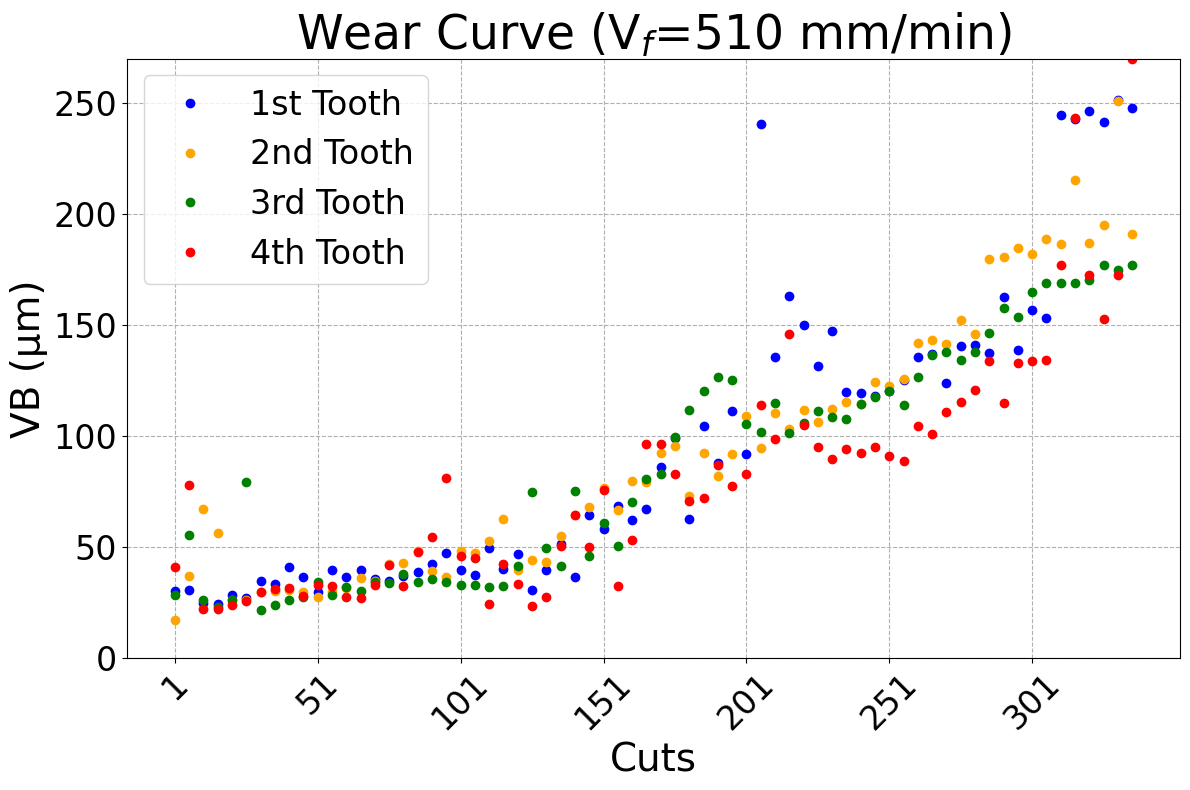

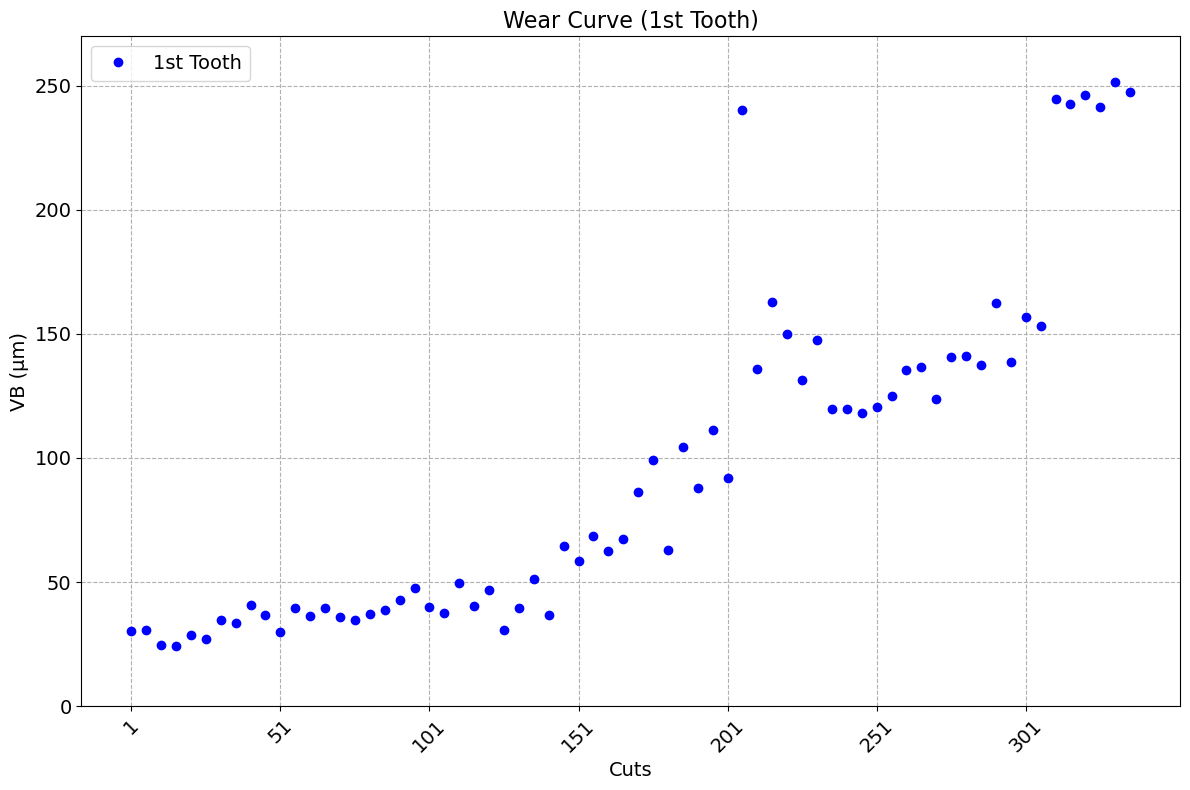

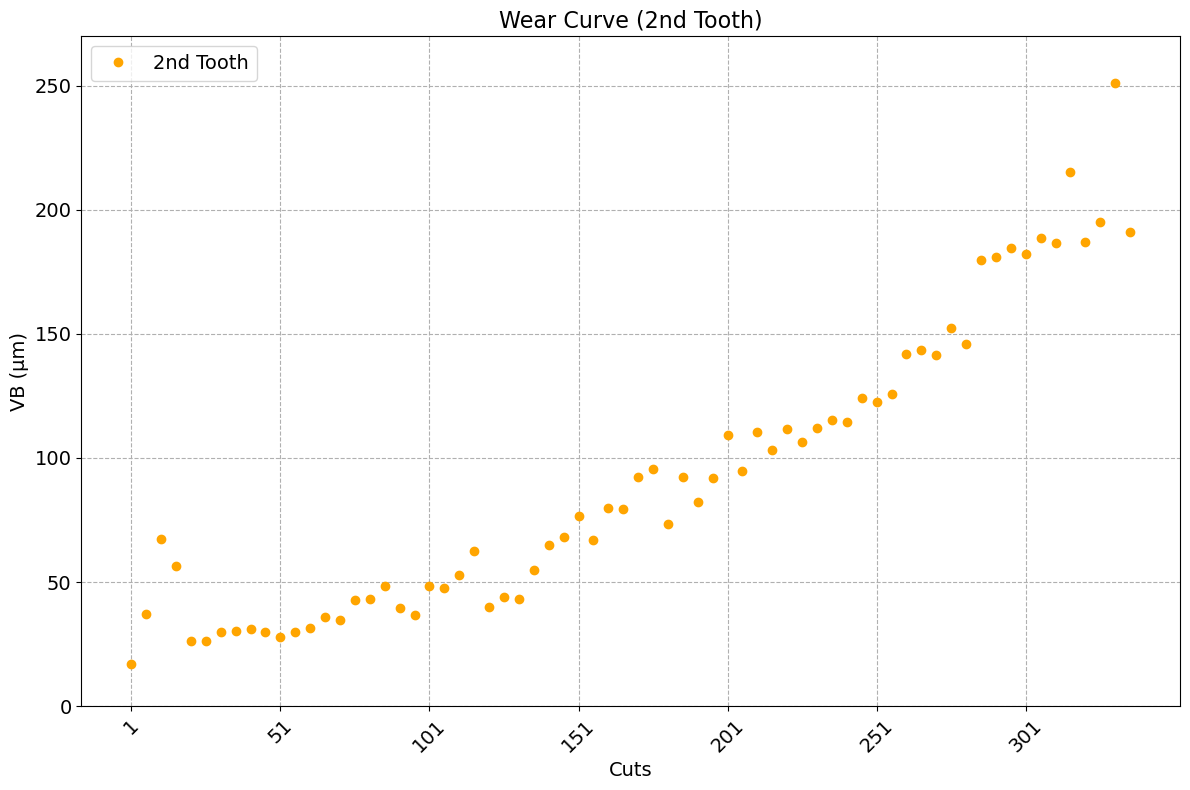

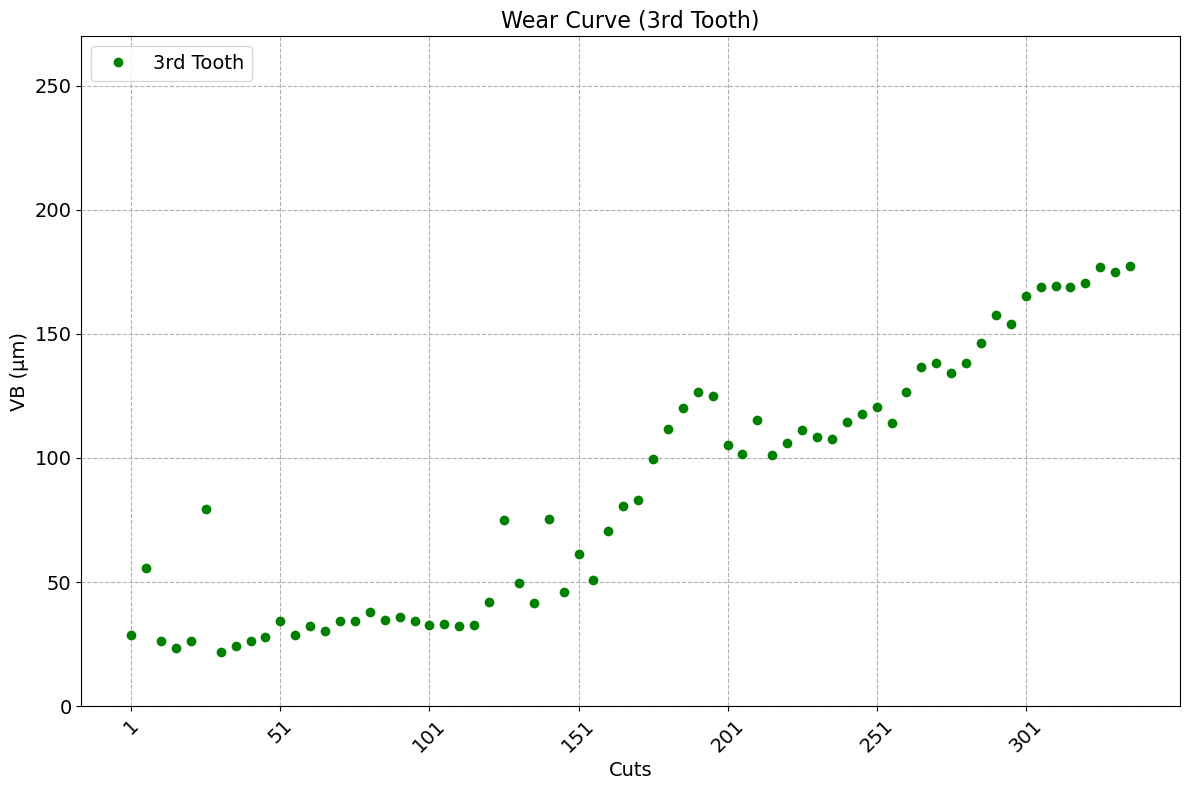

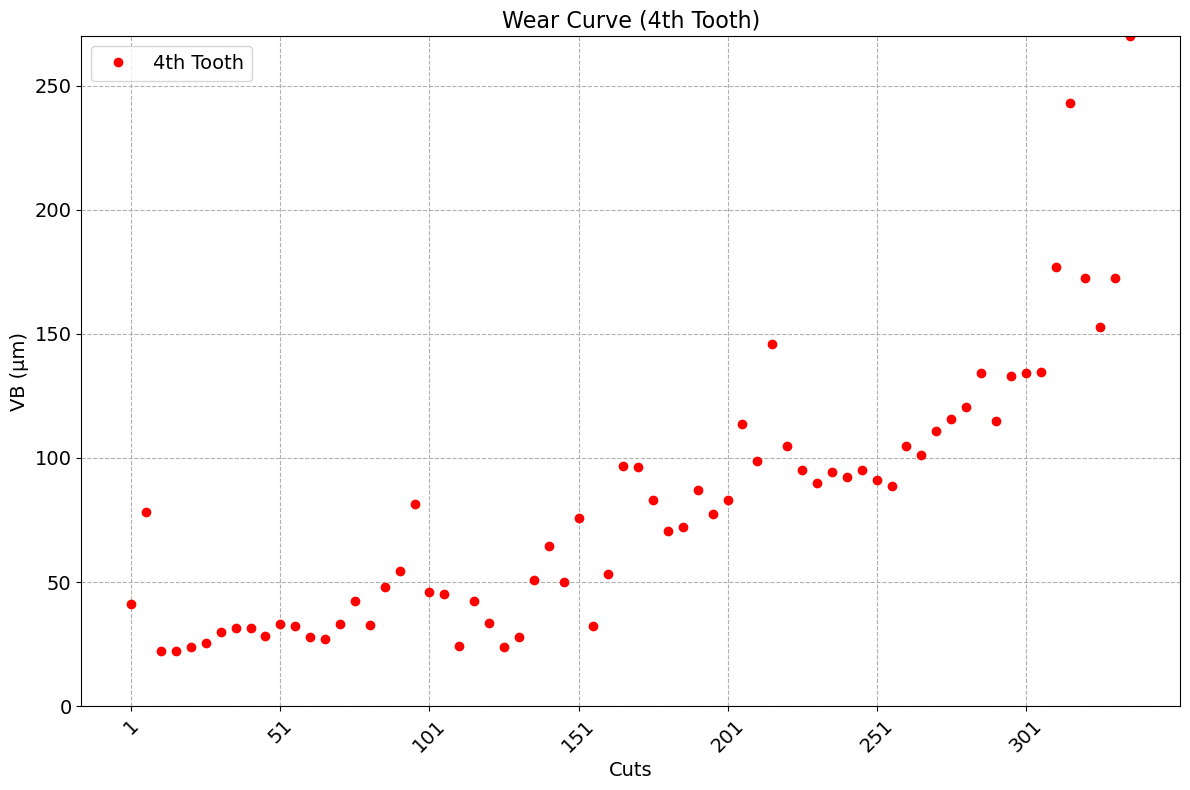

In [7]:
# Load data from Excel file
file_path = os.path.join(Wear_Analysis_Results_folder, 'VB_Data.csv')
df = pd.read_csv(file_path)

# Creating x-axis labels for all 5 cuts
x_labels = [f'{i}' for i in range(1, (df.shape[1]-1)*5, 5)]

# Create a new folder for the results
VB_Curve_results = os.path.join(current_dir, 'Image_Dataset/11_VB_Curve')
os.makedirs(VB_Curve_results, exist_ok=True)

# Get the current working directory
VB_Inp = os.path.join(current_dir, 'Image_Dataset/10_Segmentaion')

# Create the results folder if it doesn't exist
results_folder = r"D:\02-Project\01-Wear Detection\09-PROKI\BP_Tool_Wear_Measurement\Image_Dataset\10_Segmentaion\results3"
os.makedirs(results_folder, exist_ok=True)

# Define a list of colors
colors = ['blue', 'orange', 'green', 'red']

# Determine the common y-axis limit
y_min = 0
y_max = 270

# Plot the data with markers only
plt.figure(figsize=(12, 8))
for index, row in df.iterrows():
    plt.plot(df.columns[1:], row[1:], marker='o', linestyle='None', label=row['Tooth'], color=colors[index % len(colors)])

# Reduce the number of x-axis labels by selecting a subset
plt.xticks(ticks=range(0, len(x_labels), 10), labels=[x_labels[i] for i in range(0, len(x_labels), 10)], rotation=45)

plt.xlabel('Cuts', fontsize=28)
plt.ylabel('VB (μm)', fontsize=28)
plt.title('Wear Curve (V$_{f}$=510 mm/min)', fontsize=34)  # Increase the title font size
plt.legend(loc='upper left',fontsize=24)  # Increase the legend font size
plt.ylim(y_min, y_max)  # Set common y-axis limit
plt.tick_params(axis='both', which='major', labelsize=24)
plt.grid(True, linestyle='--')  # Add grid lines
plt.tight_layout()

# Full path to save the file
output_path = os.path.join(results_folder, 'VB_Curve.svg')

# Save the plot as a PNG file
plt.savefig(output_path, format='svg', dpi=300)

# Show the plot
plt.show()

# Plot each tooth separately and save
for index, row in df.iterrows():
    plt.figure(figsize=(12, 8))
    plt.plot(df.columns[1:], row[1:], marker='o', linestyle='None', label=row['Tooth'], color=colors[index % len(colors)])

    plt.xticks(ticks=range(0, len(x_labels), 10), labels=[x_labels[i] for i in range(0, len(x_labels), 10)], rotation=45)
    
    plt.xlabel('Cuts', fontsize=14)
    plt.ylabel('VB (μm)', fontsize=14)
    plt.title(f'Wear Curve ({row["Tooth"]})', fontsize=16)  # Increase the title font size
    plt.legend(loc='upper left',fontsize=14)  # Increase the legend font size
    plt.ylim(y_min, y_max)  # Set common y-axis limit
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid(True, linestyle='--')  # Add grid lines
    plt.tight_layout()

    # Full path to save the file
    individual_output_path = os.path.join(results_folder, f'VB_Curve_Tooth_{row["Tooth"]}.svg')

    # Save the plot as a PNG file
    plt.savefig(individual_output_path, format='svg', dpi=300)
    
    # Show the plot
    plt.show()


# 3. Data Fileting

Now, we can utilze a clustering methods to elemnita the errors during the segmnetsion and wear measuremnet step. A Density-based Spatial Clustering of Applications with Noise (DBSCAN) which a unsupervised learning method, is used. here we can set the impotnat paramateres 

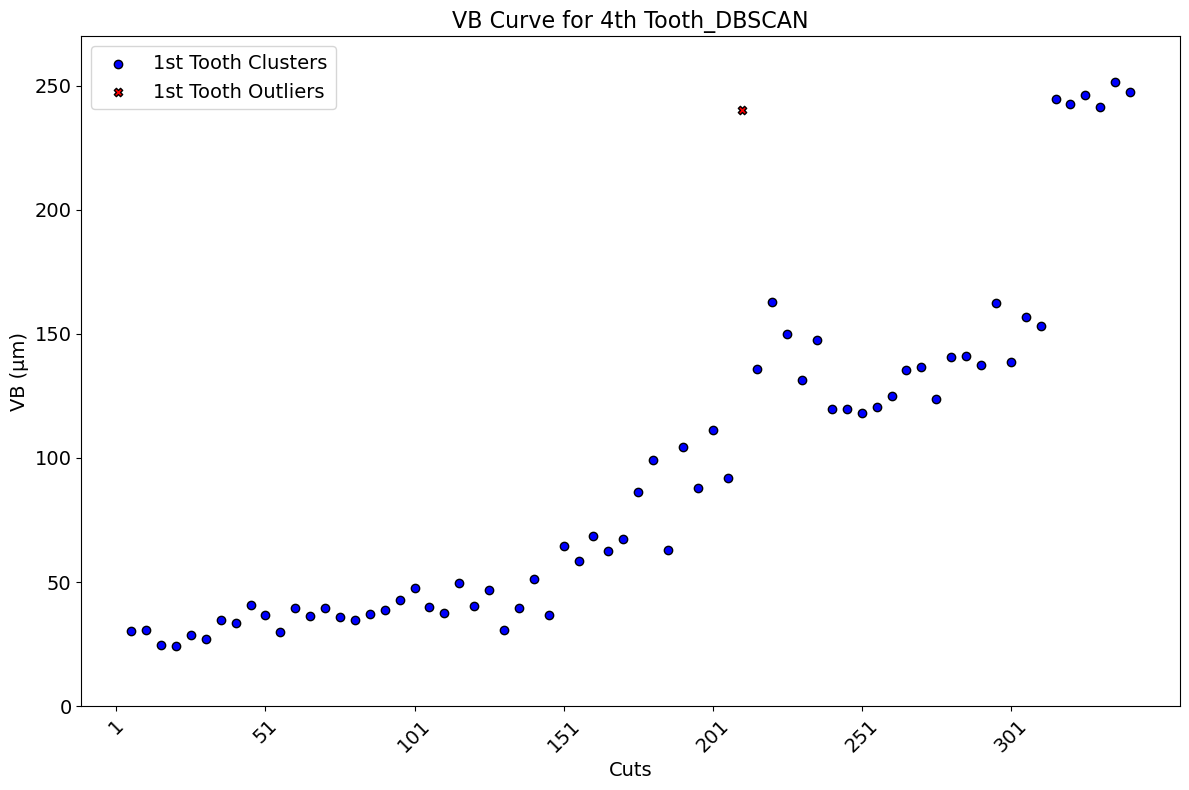

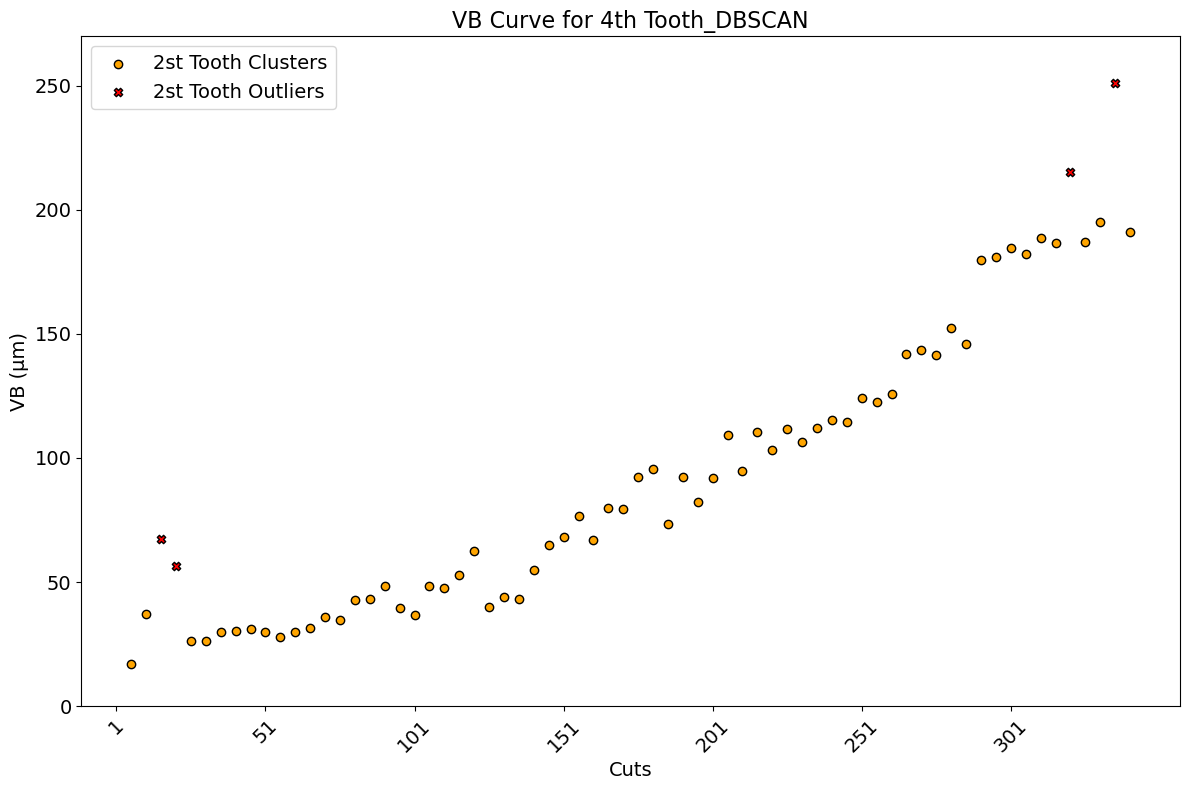

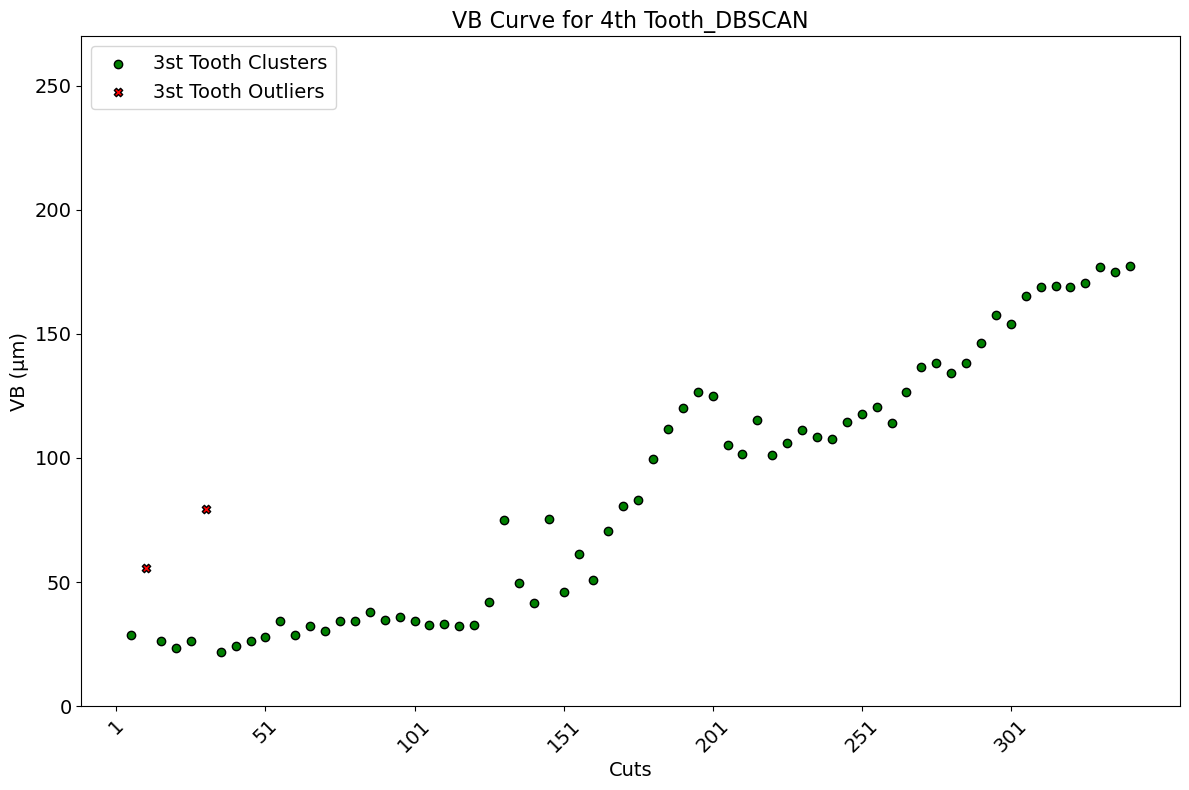

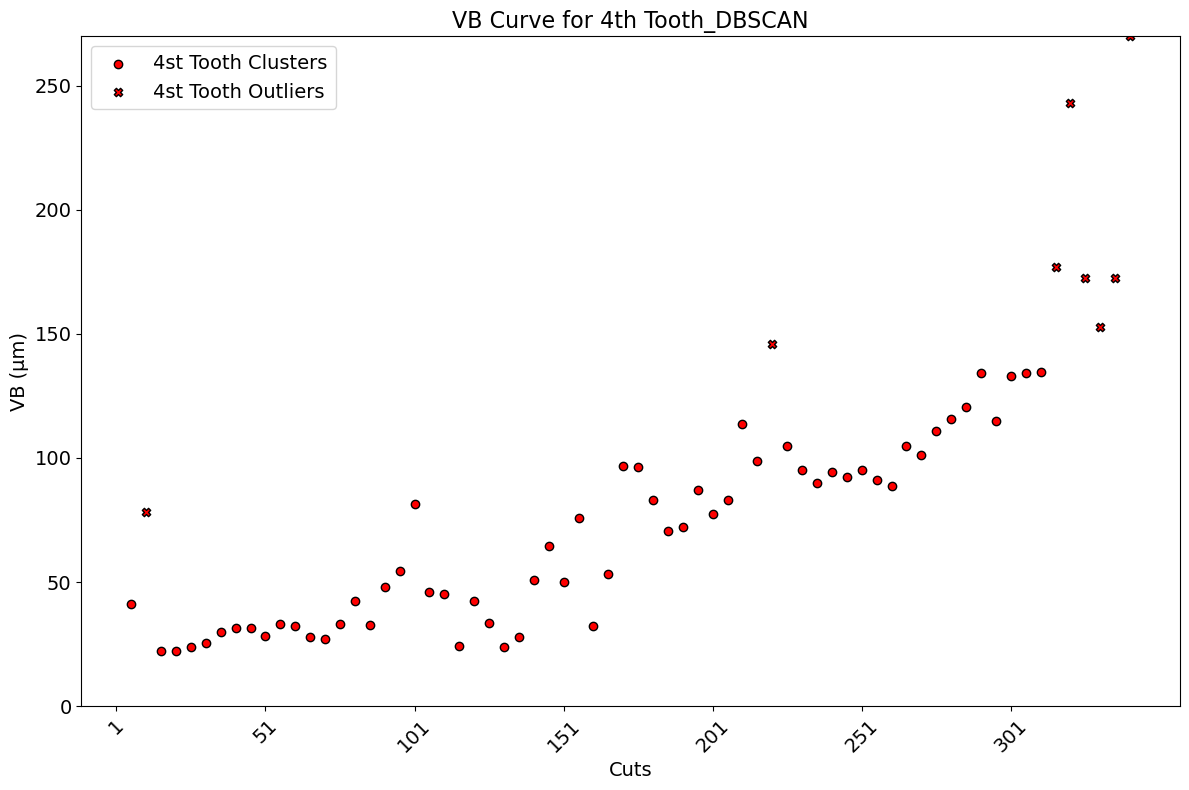

In [10]:
# Load data from Excel file
file_path = os.path.join(current_dir, 'TEST_Pixel_new_Ortagonal.csv')
df = pd.read_csv(file_path)

# Create color map for the teeth
colors = ['blue', 'orange', 'green', 'red']

# Determine the common y-axis limit
y_min = 0
y_max = 270

# Function to apply DBSCAN clustering and plot the results
def apply_dbscan_and_plot(df, tooth_index, color, output_path):
    # Extract the wear values for DBSCAN clustering
    wear_values = df.iloc[tooth_index, 1:].to_numpy()

    # Generate x-values starting from 1 to the length of wear values
    x_values = np.arange(1, len(wear_values) + 1)

    # Create the 2D data array
    data_2d = np.column_stack((x_values, wear_values))

    # Fit the DBSCAN model
    clustering = DBSCAN(eps=15, min_samples=5).fit(data_2d)

    # Extract the labels
    labels = clustering.labels_

    # Create a scatter plot for the clusters
    plt.figure(figsize=(12, 8))

    # Plot clusters in blue
    class_member_mask = (labels != -1)
    xy = data_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=color, edgecolor='k', label=f'{tooth_index + 1}st Tooth Clusters')

    # Plot outliers in red
    class_member_mask = (labels == -1)
    xy = data_2d[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c='red',  marker='X', edgecolor='k', label=f'{tooth_index + 1}st Tooth Outliers')

    # Generate x-axis labels for all cuts
    x_labels = [f'{i}' for i in range(1, (df.shape[1] - 1) * 5, 5)]

    # Reduce the number of x-axis labels by selecting a subset
    plt.xticks(ticks=range(0, len(x_labels), 10), labels=[x_labels[i] for i in range(0, len(x_labels), 10)], rotation=45)

    #plt.title(f'VB Curve_DBSCAN Clustering for Tooth {tooth_index + 1}', fontsize=16)
    plt.title(f'VB Curve for {row["Tooth"]}_DBSCAN', fontsize=16)  # Increase the title font size
    plt.xlabel('Cuts', fontsize=14)
    plt.ylabel('VB (μm)', fontsize=14)
    plt.legend(loc='upper left',fontsize=14)
    plt.ylim(y_min, y_max)  # Set common y-axis limit
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    

    # Save the plot as a PNG file
    plt.savefig(os.path.join(output_path, f'VB_Curve_DBSCAN_Tooth_{tooth_index + 1}.png'), format='png', dpi=300)

    plt.show()

# Directory to save the results
results_folder = r"D:\02-Project\01-Wear Detection\09-PROKI\BP_Tool_Wear_Measurement\Image_Dataset\10_Segmentaion\results3"
os.makedirs(results_folder, exist_ok=True)

# Apply DBSCAN and plot for each tooth
for tooth_index in range(4):
    apply_dbscan_and_plot(df, tooth_index, colors[tooth_index], results_folder)
